In [162]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from matplotlib.colors import ListedColormap

import re
import neurokit2 as nk

In [163]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.8
plt.rcParams['grid.linestyle'] = 'dotted'
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['figure.figsize'] = (4.845, 3.135)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['mathtext.default']='regular'

In [164]:
# data loading module
path_prefix = '../data'
class S1():
    def __init__(self):
        filenames = sorted(os.listdir(os.path.join(path_prefix, f'scenario_1/train/physiology')),
                           key=lambda s: (int(re.findall(r'(?<=sub_)\d+', s)[0]), int(re.findall(r'(?<=vid_)\d+', s)[0])))
        self.subs = list(set([int(re.findall(r'(?<=sub_)\d+', s)[0]) for s in filenames]))
        self.vids = list(set([int(re.findall(r'(?<=vid_)\d+', s)[0]) for s in filenames]))
        self.keys = ['ecg',' bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']
    
    def train_data(self, sub: int, vid: int):
        return pd.read_csv(os.path.join(path_prefix, f'scenario_1/train/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time"), \
            pd.read_csv(os.path.join(path_prefix, f'scenario_1/train/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")
    
    def test_data(self, sub: int, vid: int):
        return pd.read_csv(os.path.join(path_prefix, f'scenario_1/test/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time"), \
            pd.read_csv(os.path.join(path_prefix, f'scenario_1/test/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")

In [165]:
s1 = S1()
subs = s1.subs
vids = s1.vids

In [ ]:
# visualization of one subject for all videos
sub = subs[0]
vid_num = len(vids)
fig = plt.figure(figsize=(10, 4 * vid_num))
s1_train_data = []
for vid in vids:
    s1_train_data.append(s1.train_data(sub, vid))
max_length = np.max([len(s1_train_data[i][0]) for i in range(vid_num)])
max_value = np.max([[np.max(s1_train_data[i][1]['arousal']), np.max(s1_train_data[i][1]['valence'])] for i in range(vid_num)])

for i, vid in enumerate(vids):
    train_data = s1_train_data[i]
    signals, info = nk.ecg_process(train_data[0]['ecg'], sampling_rate=1000)
    
    ax = plt.subplot(vid_num, 1, i+1) 
    
    plt.xlim(0, max_length)
    plt.ylim(0, 12)
    plt.plot(signals['ECG_Raw'], label='ECG_Raw')
    plt.plot(signals['ECG_R_Peaks'], label='ECG_R_Peaks')
    plt.plot(signals['ECG_Clean'], label='ECG_Clean')
    plt.plot(signals['ECG_Rate']/10, label='Heart Rate')
    plt.plot(train_data[1]['arousal'], label='arousal')
    plt.plot(train_data[1]['valence'], label='valence')
    plt.title(f'Subject {sub}, Video {vid}')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# visualization of one video for all subjects
vid = vids[0]
sub_num = len(subs)
fig = plt.figure(figsize=(10, 4 * sub_num))
s1_train_data = []
for sub in subs:
    s1_train_data.append(s1.train_data(sub, vid))
max_length = np.max([len(s1_train_data[i][0]) for i in range(sub_num)])
max_value = np.max([[np.max(s1_train_data[i][1]['arousal']), np.max(s1_train_data[i][1]['valence'])] for i in range(sub_num)])

for i, sub in enumerate(subs):
    train_data = s1_train_data[i]
    signals, info = nk.ecg_process(train_data[0]['ecg'], sampling_rate=1000)
    
    ax = plt.subplot(sub_num, 1, i+1) 
    
    plt.xlim(0, max_length)
    plt.ylim(0, 12)
    plt.plot(signals['ECG_Raw'], label='ECG_Raw')
    plt.plot(signals['ECG_R_Peaks'], label='ECG_R_Peaks')
    plt.plot(signals['ECG_Clean'], label='ECG_Clean')
    plt.plot(signals['ECG_Rate']/10, label='Heart Rate')
    plt.plot(train_data[1]['arousal'], label='arousal')
    plt.plot(train_data[1]['valence'], label='valence')
    plt.title(f'Subject {sub}, Video {vid}')
    plt.legend()
plt.tight_layout()
plt.show()

In [166]:
# generate the parameters for epochs creating
def epochs_info_generator(data, window_size, step):
    events_onset = []
    epochs_start = []
    epochs_end = []
    cur_index = 0
    while(cur_index + window_size <= len(data)):
        events_onset.append(cur_index)
        epochs_start.append(0)
        epochs_end.append(window_size / 1000)
        cur_index += 500
    if cur_index != len(data) and cur_index + window_size > len(data):
        events_onset.append(cur_index)
        epochs_start.append(0)
        epochs_end.append((len(data) - cur_index) / 1000)
        
    return events_onset, epochs_start, epochs_end

In [178]:
def ecg_feature_extraction(sub, vid, sampling_rate, window_size, step):
    s1 = S1()
    train_data = s1.train_data(sub, vid)
    ecg = train_data[0]['ecg']
    annotations = train_data[1]
    
    signals, info = nk.ecg_process(ecg, sampling_rate=sampling_rate)
    
    events, epochs_start, epochs_end = epochs_info_generator(signals, window_size=window_size, step=step)
    windows = nk.epochs_create(signals, events, sampling_rate=sampling_rate, epochs_start=epochs_start, epochs_end=epochs_end)
    
    features = nk.ecg_analyze(splitted_signals, sampling_rate=1000, method="event-related")
    return features, annotations

In [179]:
def ecg_feature_visualization(feature_name, features, annotations):
    colors = ListedColormap(sns.color_palette('deep')).colors

    arousal_color = colors[0]
    valence_color = colors[1]
    bg_color = ListedColormap(sns.color_palette('Greys', 4)).colors[0]
    signal_color = ListedColormap(sns.color_palette('Greens', 4)).colors[3]
    
    width_per_figure = 4
    height_per_figure = 2
    n_row = 5
    n_column = 3
    fig, axes = plt.subplots(n_row, n_column, figsize=(width_per_figure * n_column, height_per_figure * n_row))
    axes = axes.flatten()
    for i, feature in enumerate(feature_name):
        axes[i].set_ylabel(f'{feature}')
        axes[i].plot(features['Event_Onset'], features[feature].to_numpy(), color=signal_color, linewidth=0.8)
        ax2 = plt.twinx(axes[i])
        ax2.plot(annotations['arousal'], label='arousal', color=arousal_color, linewidth=1.2)
        ax2.plot(annotations['valence'], label='valence', color=valence_color, linewidth=1.2)
    #     ax2.set_ylabel('Arousal and Valence')
        plt.legend()
    plt.tight_layout();

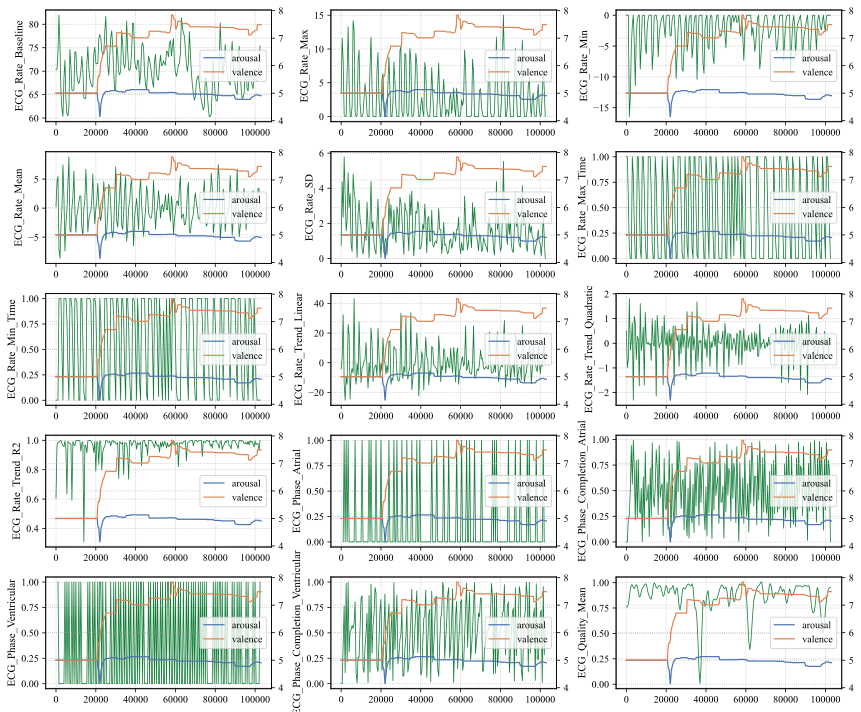

In [180]:
# loading data and processing
sub = 1
vid = 1
sampling_rate = 1000
window_size = 2000
step = 500

features, annotations = ecg_feature_extraction(sub, vid, sampling_rate=sampling_rate, window_size=window_size, step=step)
feature_name = features.columns[2:]

ecg_feature_visualization(feature_name, features, annotations)